In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

df = pd.read_csv(r"C:\Users\Amir Bismi\Desktop\EDA_PROJECT\Data\interim\cleaned_day2.csv")
df

,name,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,log_price
0,Clean & quiet apt home by the park,John,Brooklyn,Kensington,Private room,149,1,9,2018-10-19,0.21,6,365,5.010635
1,Skylit midtown castle,Jennifer,Manhattan,Midtown,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,5.420535
2,The village of harlem....new york !,Elisabeth,Manhattan,Harlem,Private room,150,3,0,2019-06-23,0.00,1,365,5.017280
3,Cozy entire floor of brownstone,Lisaroxanne,Brooklyn,Clinton hill,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,4.499810
4,Entire apt: spacious studio/loft by central park,Laura,Manhattan,East harlem,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,4.394449
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45918,Charming one bedroom - newly renovated rowhouse,Sabrina,Brooklyn,Bedford-stuyvesant,Private room,70,2,0,2019-06-23,0.00,2,9,4.262680
45919,Affordable room in bushwick/east williamsburg,Marisol,Brooklyn,Bushwick,Private room,40,4,0,2019-06-23,0.00,2,36,3.713572
45920,Sunny studio at historical neighborhood,Ilgar & aysel,Manhattan,Harlem,Entire home/apt,115,10,0,2019-06-23,0.00,1,27,4.753590
45921,43rd st. time square-cozy single bed,Taz,Manhattan,Hell's kitchen,Shared room,55,1,0,2019-06-23,0.00,6,2,4.025352


### **FEATURE ENGINEERING**

**Objective:** Create new variables that capture business value and improve analytical insights beyond raw Airbnb data.
 
   1. **price_per_review** : Measure pricing relative to booking activity.
   2. **host_type** : Distinguish between professional hosts and single-property hosts.
   3. **high_availability** : Capture listing availability intensity.
   4. **luxury_listing** : Identify high-end listings.
   5. **price_category** : Segment listings into pricing tiers for market analysis.
   6. **review_rate** : Estimate booking intensity.  

In [51]:
# 1 price per review
df['price_per_review'] = df['price'] / (df['number_of_reviews'] + 1)

# 2 host type
df['host_type'] = df['calculated_host_listings_count'].apply(
    lambda x: 'multi_host' if x>1 else 'single_host')

# 3 high availability
df['high_availability'] = (df['availability_365'] > 200).astype(int)

# 4 luxury listing
df['luxury_flag'] = (df['price'] > 200).astype(int)

# 5 price category
df['price_category'] = pd.cut(
    df['price'],
    bins=[-np.inf, 50, 150, 300, np.inf],
    labels=['low','medium','high','luxury'])

# 6 review rate
df['review_rate'] = df['number_of_reviews'] / (df['availability_365']+1)


### **TIME-BASED ANALYSIS** 

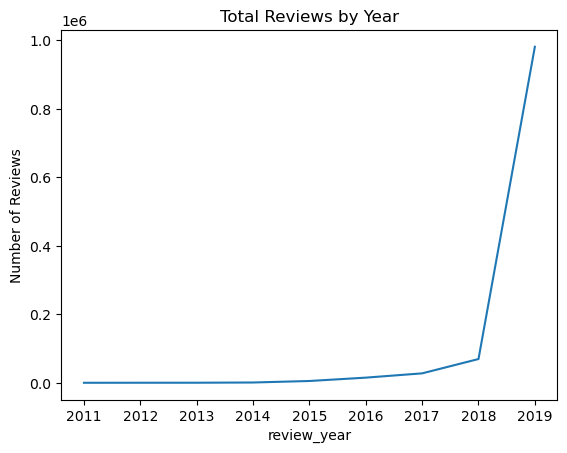

In [57]:
df['last_review'] = pd.to_datetime(df['last_review'])
df['review_year'] = df['last_review'].dt.year

df.groupby('review_year')['number_of_reviews'].sum().plot()
plt.title("Total Reviews by Year")
plt.ylabel("Number of Reviews")
plt.show()

### **STATISTICAL HYPOTHESIS TESTING**

We use a significance level of **0.05**.
   1. **T-Test:**  Do entire home listings have a higher average price than private room listings?
   2. **Chi-Square Test:**  Is room type distribution related to neighbourhood group?
   3. **ANOVA:**  Does neighbourhood group impact listing price?


In [53]:
#T-Test
from scipy.stats import ttest_ind

entire = df[df['room_type']=='Entire home/apt']['price']
private = df[df['room_type']=='Private room']['price']

stat, p_val = ttest_ind(entire, private, equal_var=False)
print(p_val)

0.0


In [54]:
#Chi-Square
from scipy.stats import chi2_contingency
table = pd.crosstab(df['room_type'], df['neighbourhood_group'])
chi, p_val, dof, exp = chi2_contingency(table)
print(p_val)

3.420395121479403e-252


In [55]:
from scipy.stats import f_oneway

brooklyn = df[df['neighbourhood_group']=='Brooklyn']['price']
manhattan = df[df['neighbourhood_group']=='Manhattan']['price']
queens = df[df['neighbourhood_group']=='Queens']['price']
bronx = df[df['neighbourhood_group']=='Bronx']['price']
staten = df[df['neighbourhood_group']=='Staten island']['price'] 
stat, p_val = f_oneway(brooklyn, manhattan, queens, bronx, staten)

print("ANOVA p-value:", p_val)



ANOVA p-value: 0.0


## **Findings & Insights**
### 1️. **T-Test:** Price vs Room Type

**Question:** Do entire homes have higher prices than private rooms?

**Result:**
p-value < 0.05 → Significant difference

**Findings:**
- Entire home listings have significantly higher average prices.
- Private rooms are consistently cheaper.
- Room type strongly influences listing price.

**Insight:**
Property type is a primary pricing driver in the Airbnb market. 

**Business implication:**
Hosts seeking higher revenue should list entire homes where possible.
Budget travelers mainly book private rooms.

---

### 2️. **Chi-Square Test:** Room Type vs Location

**Question:** Is room type distribution related to location?

**Result:**
p-value < 0.05 → Significant relationship

**Findings:**
- Room type distribution varies by neighbourhood.
- Central locations have more entire homes.
- Some boroughs have more private rooms.

**Insight:**
Location determines what type of listing performs best.

**Business implication:**
Hosts should choose listing type based on area demand patterns.

---

### 3️. **ANOVA:** Price vs Location

**Question:** Does location affect price?

**Result:**
p-value < 0.05 → Significant difference

**Findings:**

- Average prices differ significantly across locations.
- Manhattan has highest prices.
- Bronx and outer areas have lower prices.
- Location is a major pricing factor.

**Insight:**
Airbnb pricing is highly location-dependent.

**Business implication:**
Hosts must adjust pricing strategy based on neighbourhood.

# Executive Summary: Strategic Insights & Recommendations

## Overview  
This analysis examined Airbnb listings to understand the key factors influencing pricing, demand, and listing performance. Using exploratory data analysis and statistical hypothesis testing, we identified the most important drivers of price and booking activity across different room types and neighbourhoods.

---

## Key Strategic Insights

### 1. Pricing Drivers  
Room type and location are the strongest determinants of Airbnb pricing.

- Entire home listings command significantly higher prices than private or shared rooms.  
- Manhattan and central areas have the highest average prices.  
- Outer boroughs such as Bronx and Queens offer lower-priced listings.

**Recommendation:**  
Hosts should align pricing with both property type and location. Premium pricing is sustainable for entire homes in high-demand areas, while competitive pricing is necessary in outer boroughs.

---

### 2. Market Segmentation  
The Airbnb market is divided into two main segments:

- **Premium segment:** Entire homes in central locations  
- **Budget segment:** Private rooms and listings in outer areas  

Lower-priced listings tend to receive more reviews, indicating higher booking frequency and occupancy.

**Recommendation:**  
Hosts targeting high occupancy should consider competitive pricing strategies, while hosts targeting higher revenue per booking should focus on entire home listings.

---

### 3. Location-Based Strategy  
Statistical testing confirmed that location significantly impacts pricing and listing distribution.

- Manhattan → highest revenue potential but highest competition  
- Brooklyn → strong demand with moderate pricing  
- Bronx/Staten Island → lower prices but lower competition  

**Recommendation:**  
New hosts entering the market may find opportunities in lower-competition areas, while experienced hosts can maximize revenue in premium locations.

---

### 4. Demand & Engagement Patterns  
Time-based analysis of reviews shows that recent years have higher engagement levels, indicating increased platform activity and demand. Lower-priced listings tend to accumulate more reviews, suggesting higher booking frequency.

**Recommendation:**  
Hosts should monitor market demand trends and adjust pricing dynamically to maintain occupancy and competitiveness.

---

## Final Strategic Takeaways

- Pricing strategy must consider both room type and neighbourhood.  
- Entire homes generate higher revenue but face stronger competition.  
- Budget listings achieve higher booking frequency and engagement.  
- Location determines both pricing potential and listing type demand.  
- Data-driven pricing and positioning improve listing performance.

---

## Data Quality Issues

- Some columns required type conversion (dates → datetime)
- Outliers in price distribution were present
- Price skewness required log transformation
- Feature engineering created derived variables for better analysis

---

## Conclusion  
The analysis confirms that Airbnb pricing and demand are strongly influenced by property type and location. By aligning listing strategy with these factors, hosts can optimize revenue, occupancy, and market positioning. The final processed dataset and engineered features provide a strong foundation for future dashboarding, predictive modeling, and advanced market analysis.


In [49]:
df.to_csv(r"C:\Users\Amir Bismi\Desktop\EDA_PROJECT\Data\final\final_cleaned_day4.csv", index=False)